## Import the libraries

In [1]:
# import the necessary packages
#%tensorflow_version 2.x
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
%matplotlib inline

c:\users\ai_iot\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\ai_iot\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\ai_iot\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\ai_iot\

In [2]:
# initialize directory 
dataset="data/train/"

dataset_dir = os.path.join(dataset)

model_name="covid19.model"

In [3]:
args={}
args["dataset"]=dataset

In [4]:
#from IPython.display import Image, display
#display(Image('NORMAL2-IM-0315-0001.jpeg',width=120))
#print("Normal")


In [5]:
#from IPython.display import Image, display
#display(Image('Test0.jpg',width=120))
#print("Kovid19")

In [6]:
train_LUNG_dir     = os.path.join(dataset_dir, 'Lung')  # directory with our training Covid pictures
train_Normal_dir    = os.path.join(dataset_dir, 'Normal')  # directory with our training Normal pictures


num_LUNG_dir     = len(os.listdir(train_LUNG_dir))
num_Normal_dir    = len(os.listdir(train_Normal_dir))


print('Total Train LUNG-19  images:', num_LUNG_dir)
print('Total Train Normal    images:', num_Normal_dir)


os.listdir(dataset)

Total Train LUNG-19  images: 335
Total Train Normal    images: 325


['lung', 'Normal']

In [7]:
image_gen = ImageDataGenerator(rotation_range=30,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')
BS = 2
batch_size = BS
train_image_gen = image_gen.flow_from_directory('data/train',
                                               target_size=(224,224,3),
                                               batch_size=2,
                                               class_mode='binary')

test_image_gen = image_gen.flow_from_directory('data/test',
                                               target_size=(224,224,3),
                                               batch_size=2,
                                               class_mode='binary')



Found 659 images belonging to 2 classes.
Found 271 images belonging to 2 classes.


In [8]:
train_image_gen.class_indices

{'Normal': 0, 'lung': 1}

In [9]:
# dataset_path = '/tmp/covid_xray_dataset/'
import glob
dataset_path = 'data/train'
image_paths=[image_path for image_path in glob.glob(dataset_path+'/*/*')]
image_categories=[os.path.basename(os.path.dirname(image_path)) for image_path in image_paths]
filenames=[os.path.basename(image_path) for image_path in image_paths]

In [10]:
import pandas as pd

dataset_df = pd.DataFrame({'image_paths':image_paths,'filename':filenames,'image_category':image_categories})
dataset_df.sort_values('image_category',inplace=True)
dataset_df.tail(3)

,image_paths,filename,image_category
223,data/train\lung\a90fb4b284cc112c2a5c33263e839f...,a90fb4b284cc112c2a5c33263e839f2e_result.png,lung
225,data/train\lung\a9ca4c85c1e67d3c19092dc85ba6fb...,a9ca4c85c1e67d3c19092dc85ba6fb1b_result.png,lung
329,data/train\lung\fb853dae3a9668928590926b29e2b3...,fb853dae3a9668928590926b29e2b3c1_result.png,lung


In [11]:
#img_pred = image.load_img('2020.02.19.20025023-p20-93%0.png', image_categories)


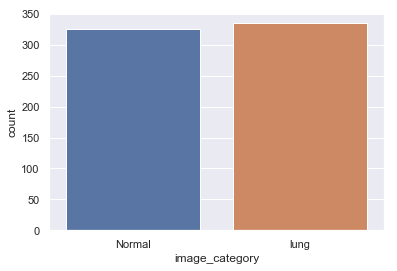

In [12]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="image_category", data=dataset_df)

In [13]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 5
BS = 15

In [14]:
imagePaths = list(paths.list_images(dataset))
data = []
labels = []

In [15]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)


In [16]:
labels.shape


(659,)

In [17]:
labels[5]

'data/train/lung'

In [18]:
print(labels)

['data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lung' 'data/train/lung'
 'data/train/lung' 'data/train/lung' 'data/train/lu

In [19]:
labels[1]

'data/train/lung'

In [20]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
num_labels=le.fit_transform(labels)
cat_labels=le.inverse_transform(num_labels)

In [21]:
num_labels.shape

(659,)

In [22]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder=OneHotEncoder(sparse=False)
num_labels=num_labels.reshape(len(num_labels),1)
onehot_encoded=onehot_encoder.fit_transform(num_labels)

c:\users\ai_iot\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [23]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
#labels = lb.fit_transform(labels [:,None])
labels = to_categorical(num_labels )

In [24]:


# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, onehot_encoded,test_size=0.20, stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

## Build the model

In [29]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [30]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])



[INFO] compiling model...


In [31]:
#from sklearn.preprocessing import OneHotEncoder
#onehot_encoder=OneHotEncoder(sparse=False)
#num_labels=num_labels.reshape(len(num_labels),1)
#onehot_encoded=onehot_encoder.fit_transform(num_labels)

## Training the model

In [32]:
# train the head of the network
print("[INFO] training head...")
EPOCHS = 3
BS = 5
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
105/105 [==============================] - 744s 7s/step - loss: 0.5020 - acc: 0.7720 - val_loss: 0.2228 - val_acc: 0.9924
Epoch 2/3
105/105 [==============================] - 724s 7s/step - loss: 0.1872 - acc: 0.9674 - val_loss: 0.1039 - val_acc: 0.9924
Epoch 3/3
105/105 [==============================] - 733s 7s/step - loss: 0.0997 - acc: 0.9885 - val_loss: 0.0492 - val_acc: 1.0000


In [33]:
import seaborn as sns
predicted_metrics = model.evaluate(testX, testY,batch_size=BS, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)
print()

#plot_cm(trueIdxs, predIdxs)
#plt.savefig('confusion_matrix.pdf', format='pdf')

loss :  0.04971292406094797
acc :  1.0



## Test the model

In [34]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

#target_names=lb.inverse_transform

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00        67

   micro avg       1.00      1.00      1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132



In [35]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[65  0]
 [ 0 67]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [93]:
def plot_cm(labels, predictions):
    '''
    Plot the confusion matrix
    '''
    print(classification_report(labels, predictions))
    #target_names=lb.classes_
    cm = confusion_matrix(labels, predictions)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    print("accuracy: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))
    print()
    print('Correct Healthy Patient Detection (True Negatives): ', cm[0][0])
    print('Incorrect LUNG Detection (False Positives): ', cm[0][1])
    print('Incorrect Healthy Patient Detection (False Negatives): ', cm[1][0])
    print('Correct LUNG Detection (True Positives): ', cm[1][1])
    print('Total Patietns with LUNG: ', np.sum(cm[1]))

    print()
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [94]:
# Make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
print('\nNumber of test scans: ', len(testX))
print('Predicted class probabilities:')
print(predIdxs)

    
# Find the predicted labels 
predIdxs = np.argmax(predIdxs, axis=1)
print('\nPredicted outcome (Normal=0, lung=1):')
print(predIdxs)
print('Ground-truth outcome:')
# print(testY)
trueIdxs = np.argmax(testY, axis=1)
print(trueIdxs)



[INFO] evaluating network...

Number of test scans:  132
Predicted class probabilities:
[[0.37354943 0.6264506 ]
 [0.97151834 0.02848173]
 [0.99461937 0.00538058]
 [0.01662537 0.9833746 ]
 [0.09241039 0.90758955]
 [0.02933232 0.97066766]
 [0.03423264 0.9657674 ]
 [0.04330009 0.9566999 ]
 [0.02261628 0.97738373]
 [0.95471823 0.04528173]
 [0.05389051 0.9461095 ]
 [0.05355888 0.9464412 ]
 [0.01953536 0.9804646 ]
 [0.9678289  0.0321711 ]
 [0.95315236 0.04684766]
 [0.02457923 0.9754208 ]
 [0.38548997 0.61451   ]
 [0.9851128  0.01488721]
 [0.94195867 0.05804138]
 [0.9748473  0.02515265]
 [0.9825195  0.01748047]
 [0.98823416 0.01176577]
 [0.8881787  0.11182133]
 [0.0352125  0.9647875 ]
 [0.0192192  0.9807808 ]
 [0.97135115 0.02864881]
 [0.8895721  0.11042786]
 [0.02693832 0.9730617 ]
 [0.23764586 0.76235414]
 [0.9787764  0.02122364]
 [0.97121453 0.02878543]
 [0.9865196  0.01348034]
 [0.95421314 0.04578691]
 [0.01241818 0.98758185]
 [0.02824022 0.97175974]
 [0.9555233  0.04447673]
 [0.0208307 

loss :  0.04971292406094797
acc :  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00        67

   micro avg       1.00      1.00      1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132

accuracy: 1.0000
sensitivity: 1.0000
specificity: 1.0000

Correct Healthy Patient Detection (True Negatives):  65
Incorrect LUNG Detection (False Positives):  0
Incorrect Healthy Patient Detection (False Negatives):  0
Correct LUNG Detection (True Positives):  67
Total Patietns with LUNG:  67



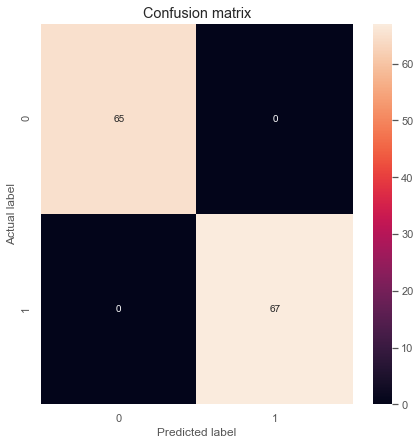

In [95]:
import seaborn as sns
predicted_metrics = model.evaluate(testX, testY,batch_size=BS, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)
print()

plot_cm(trueIdxs, predIdxs)
#plt.savefig('confusion_matrix.pdf', format='pdf')

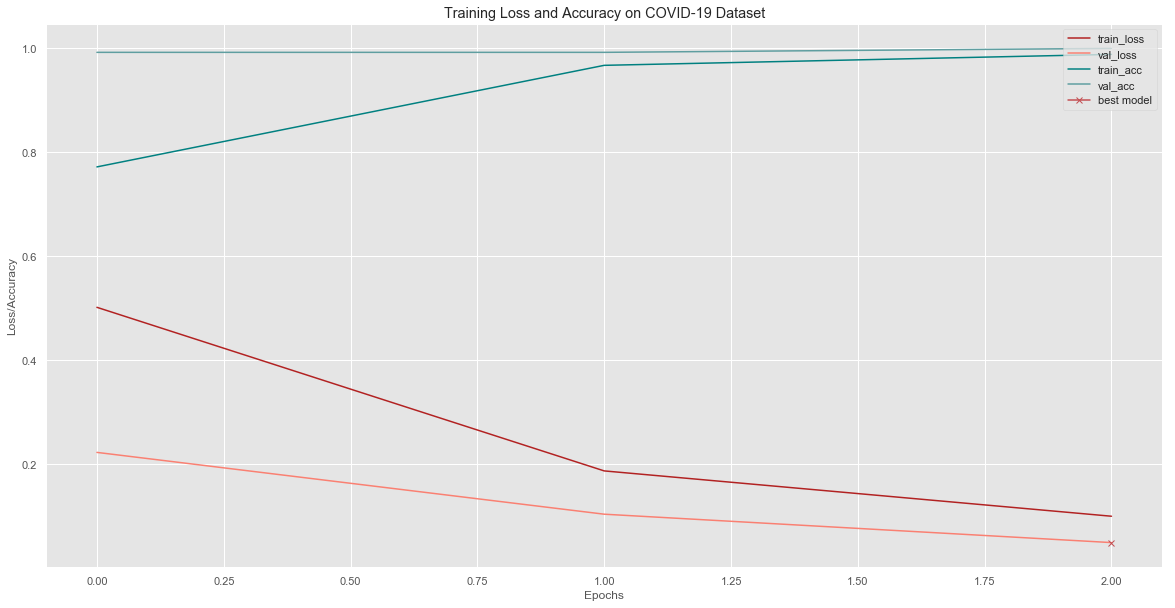

In [39]:
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (20,10))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss", color = 'firebrick')
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss", color = 'salmon')
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc", color = 'teal')
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc",color = 'cadetblue')
plt.plot( np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]), marker="x", color="r", label="best model")
plt.title("Training Loss and Accuracy on LUNG Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig('loss_curve.pdf', format='pdf')
plt.show()

In [40]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[65  0]
 [ 0 67]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


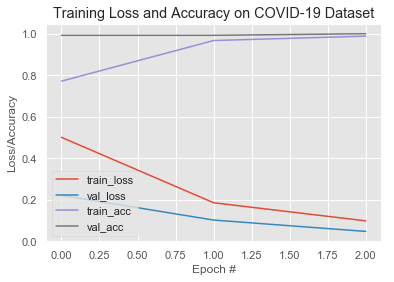

<Figure size 432x288 with 0 Axes>

In [41]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on LUNG Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig("plot.png")

Using TensorFlow backend.


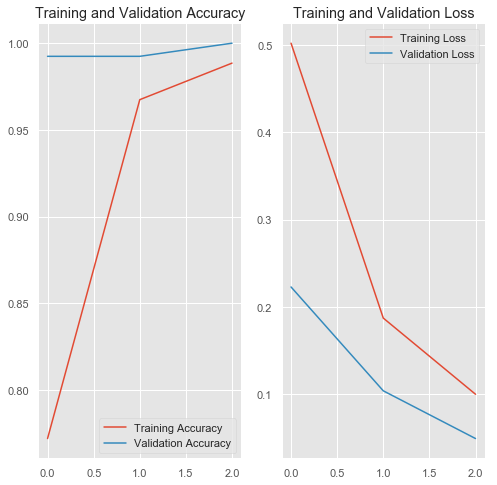

In [42]:
from keras.callbacks import ModelCheckpoint,History,EarlyStopping,LearningRateScheduler
acc = H.history['acc']
val_acc = H.history['val_acc']

loss = H.history['loss']
val_loss = H.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
# serialize the model to disk
print("[INFO] saving LUNG detector model...")
model.save(model_name, save_format="h5")
model.save('FullModelDetect_Kovid_Ardabil.h5')
print("Saved Model : Detect_LUNG_Ardabil in Folder Successfuly")


[INFO] saving COVID-19 detector model...
Saved Model : Detect_LUNG_Ardabil in Folder Successfuly


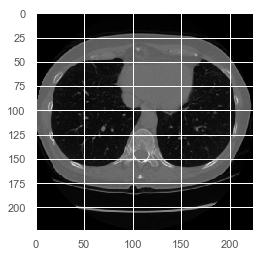

acc : = [0.77203065, 0.967433, 0.9885057]
Prediction : = <function predict at 0x000002571F85A1E0>
Actual : = <function predict at 0x000002571F85A1E0>


In [58]:
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import load_model
import matplotlib.pyplot as plt

#model=load_model("/content/drive/My Drive/covid19-dataset/covid191.h5")
_img=load_img("Lung-1.png",target_size=(224,224))
img=img_to_array(_img)
img=np.expand_dims(img,axis=0)
img=preprocess_input(img)
#plt.subplot(1,2,1)
plt.imshow(_img)
#plt.subplot(1,2,2)
#plt.imshow(img)
plt.show()
features=model.predict(img)

print('acc : =' ,acc )
print('Prediction : =' ,predict )
print('Actual : =' ,predict )
#for GradCAM
class_idxs_sorted = np.argsort(features.flatten())[::-1]

{'Normal': 0, 'lung': 1}
1.0
acc : = [0.77203065, 0.967433, 0.9885057]
Prediction : = Normal
Actual : = Normal


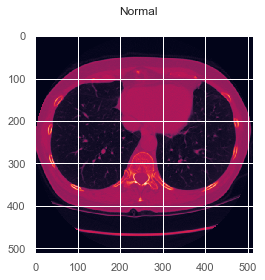

In [59]:
import cv2
import matplotlib.image as mpimg
img_src = 'Lung-1.png'
img = cv2.imread(img_src)
img_pred = load_img('Lung-1.png', target_size = (224, 224))
img_pred = img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis = 0)
rslt = model.predict(img_pred)
ind = train_image_gen.class_indices
print(ind)


#train_image_gen.class_indices
classnumber=np.argmax(rslt[0])
classnames=["Normal","Lung"]
prediction=classnames[np.argmax(rslt[0]*100)]
#prediction=('%.2f' % (probability[1]*100)
score=rslt[0][classnumber]
print(score)

target_width = 50
target_height = 50
target_size = (target_width, target_height)
img = cv2.resize(img, target_size)
img = img.reshape(1, target_width, target_height, 3)
fig, ax = plt.subplots()
fig.suptitle(prediction, fontsize=12)
np_img = mpimg.imread(img_src)
plt.imshow(np_img)
print('acc : =' ,acc )
print('Prediction : =' ,prediction )
print('Actual : =' ,prediction )

this is a Normal
intensity =  1.0
acc : = [0.77203065, 0.967433, 0.9885057]
Prediction : = Normal
Actual : = Normal
Comment =


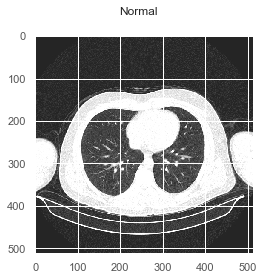

In [89]:
import cv2
import matplotlib.image as mpimg
img_src = 'Train_Normal(294).jpg'
img = cv2.imread(img_src)
img_pred = load_img('Train_Normal(294).jpg', target_size = (224, 224))
img_pred = img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis = 0)
rslt = model.predict(img_pred)
ind = train_image_gen.class_indices
#print(ind)


#train_image_gen.class_indices
classnumber=np.argmax(rslt[0])
classnames=["Normal","Lung"]
prediction=classnames[np.argmax(rslt[0]*100)]
#prediction=('%.2f' % (probability[1]*100)
score=rslt[0][classnumber]


if prediction[0]:
    print("this is a Normal")
else:
    print("this is a LUNG,The image in question is suspicious. Examine by a specialist.")
    
print("intensity = ",score)
target_width = 50
target_height = 50
target_size = (target_width, target_height)
img = cv2.resize(img, target_size)
img = img.reshape(1, target_width, target_height, 3)
fig, ax = plt.subplots()
fig.suptitle(prediction, fontsize=12)
np_img = mpimg.imread(img_src)
plt.imshow(np_img)
print('acc : =' ,acc )
print('Prediction : =' ,prediction )
print('Actual : =' ,prediction )
print( "Comment =" )

In [61]:
yes_votes = 42_572_654
no_votes = 43_132_495
percentage = yes_votes / (yes_votes + no_votes)
'{:-9} YES votes  {:2.2%}'.format(yes_votes, percentage)

' 42572654 YES votes  49.67%'

In [ ]:
#if prediction==0:
#    print ("helllo")
#print("The CT Chest Is of {prediction} is {prediction}".format(prediction="LUNG"))
        

#if prediction==0:
#    'YES votes  {:2.2%}'.format(prediction)
#else:
#    'No votes  {:2.2%}'.format(prediction)